<a href="https://www.kaggle.com/code/charunumesh/ps-s3-e12-eda-ensemble?scriptVersionId=125967471" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
import category_encoders as ce
import optuna
 
from sklearn.model_selection import train_test_split,  StratifiedKFold, KFold,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix,roc_auc_score

import warnings 
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


## Import the Data

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
df_train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [3]:
len(df_train)

414

In [4]:
df_test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
df_test.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


In [5]:
len(df_test)

276

In [6]:
### Remove the id column

df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

In [7]:
df_train.dtypes

gravity    float64
ph         float64
osmo         int64
cond       float64
urea         int64
calc       float64
target       int64
dtype: object

In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


In [9]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,276.0,1.018330,0.006569,1.005,1.0140,1.019,1.02325,1.034
ph,276.0,5.939312,0.607143,4.900,5.5300,5.730,6.21000,7.940
osmo,276.0,654.891304,236.361932,187.000,456.0000,658.000,843.25000,1236.000
cond,276.0,21.886594,7.346069,5.100,17.4000,23.600,27.60000,38.000
urea,276.0,280.985507,134.877856,64.000,168.5000,282.000,385.00000,620.000
calc,276.0,4.076848,3.088524,0.170,1.5275,3.230,5.54000,14.340


## Exploratory Data Analysis

In [10]:
### check the null values

df_train.isnull().sum()

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

In [11]:
df_test.isnull().sum()

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
dtype: int64

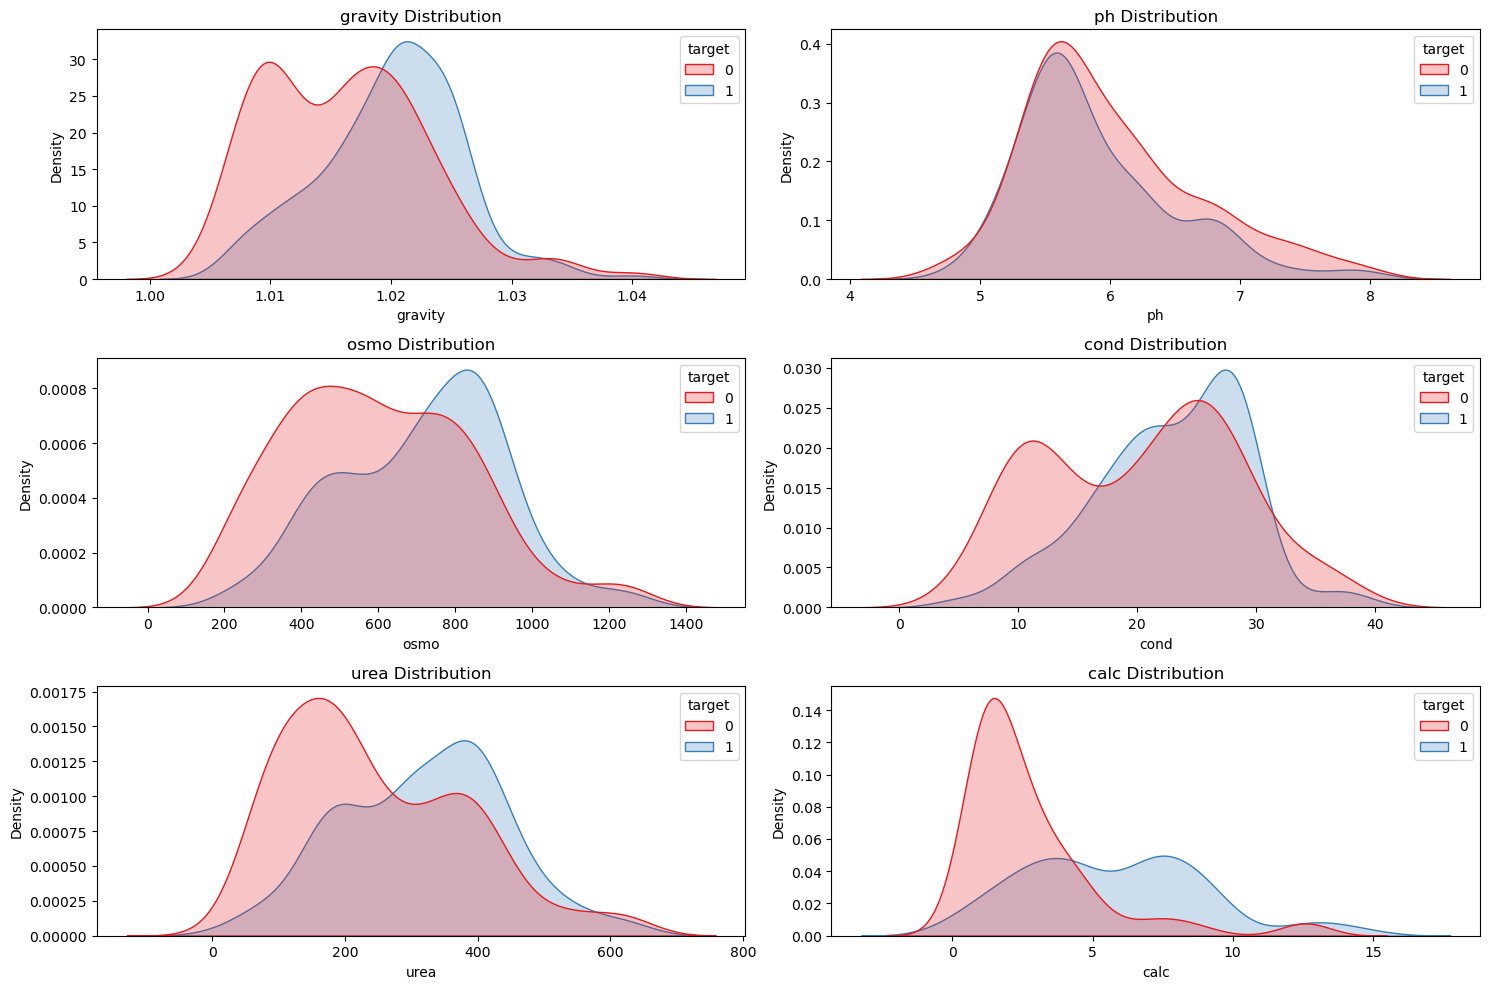

In [12]:
# Distribution of each and every feature
plt.figure(figsize=(15,10))
for id,column in enumerate(df_train.columns[:-1]):
    plt.subplot(3,2,id+1)
    sns.kdeplot(x=column,data=df_train, hue='target',  palette="Set1", fill=True)
    plt.title(f"{column} Distribution")

    plt.tight_layout()

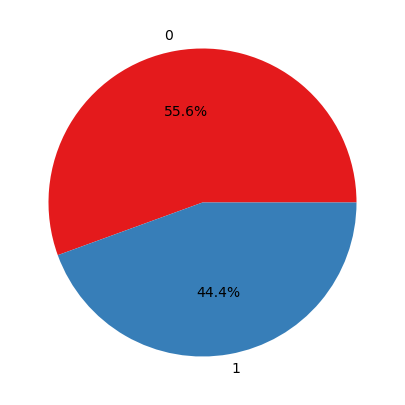

In [13]:
# check the class imbalance
data = df_train['target'].value_counts()
labels = df_train['target'].value_counts().keys()

fig = plt.figure(figsize =(8, 5))
plt.pie(data, labels = labels, autopct="%1.1f%%", colors=sns.color_palette("Set1"))
 
# show plot
plt.show()

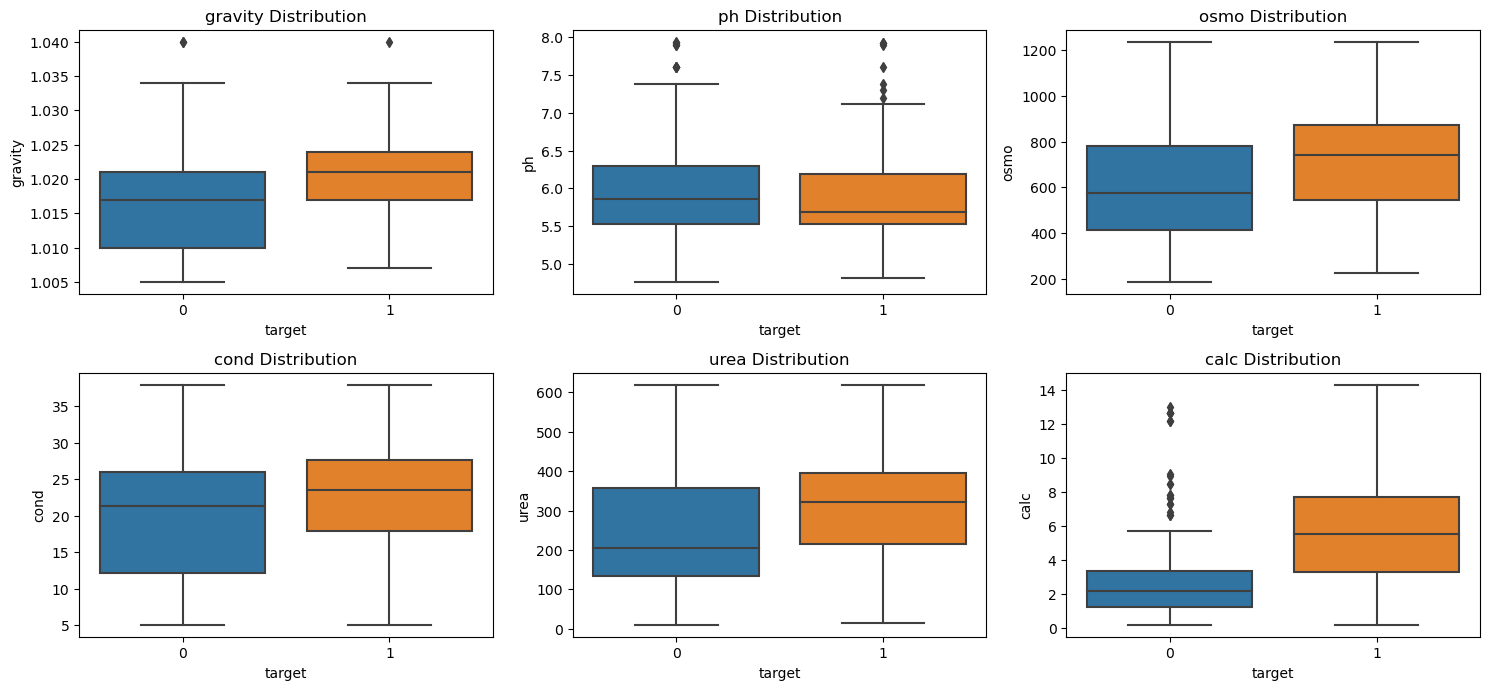

In [14]:
# visaulize distribution with boxplot
plt.figure(figsize=(15,10))
for id,column in enumerate(df_train.columns[:-1]):
    plt.subplot(3,3,id+1)
    sns.boxplot(x=df_train['target'], y=df_train[column])
    plt.title(f"{column} Distribution")

    plt.tight_layout()

considering the features set, we can see that there are some outliers in the dataset

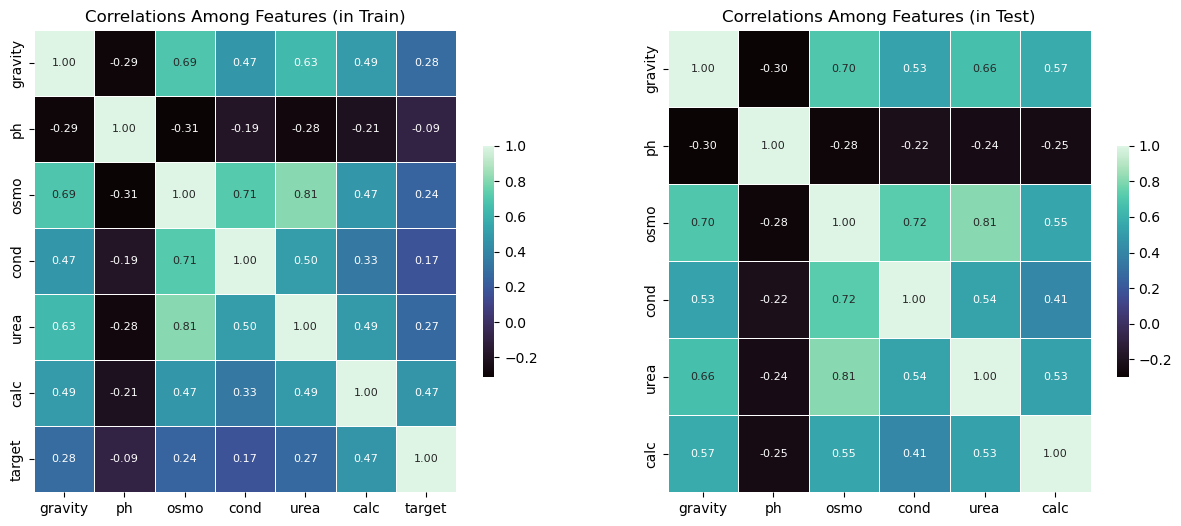

In [15]:
### checking the correlation with features

corr_mat_train = df_train.corr()
corr_mat_test = df_test.corr()

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
sns.heatmap(corr_mat_train, annot = True, cmap = 'mako', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_mat_test, annot = True, cmap = 'mako', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

osmo feature showing strong correlation with gravity, cond and urea.

In [16]:
#Drop the osmo column

df_train = df_train.drop('osmo', axis=1)
df_test = df_test.drop('osmo', axis=1)

### Treat the outliers

In [17]:
def outliers(df, columns, factor):
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - (factor*IQR)
        upper_bound = Q3 + (factor*IQR)

        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])  
        #       
    return df

In [18]:
df_train = outliers(df_train, df_train.columns, 1.5)
df_test= outliers(df_test, df_test.columns, 1.5)

### Feature Importance

In [19]:
X = df_train.drop('target', axis=1)
y = df_train['target']

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

In [21]:
rf = RandomForestClassifier(max_depth=8, n_estimators=10, random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=10, random_state=42)

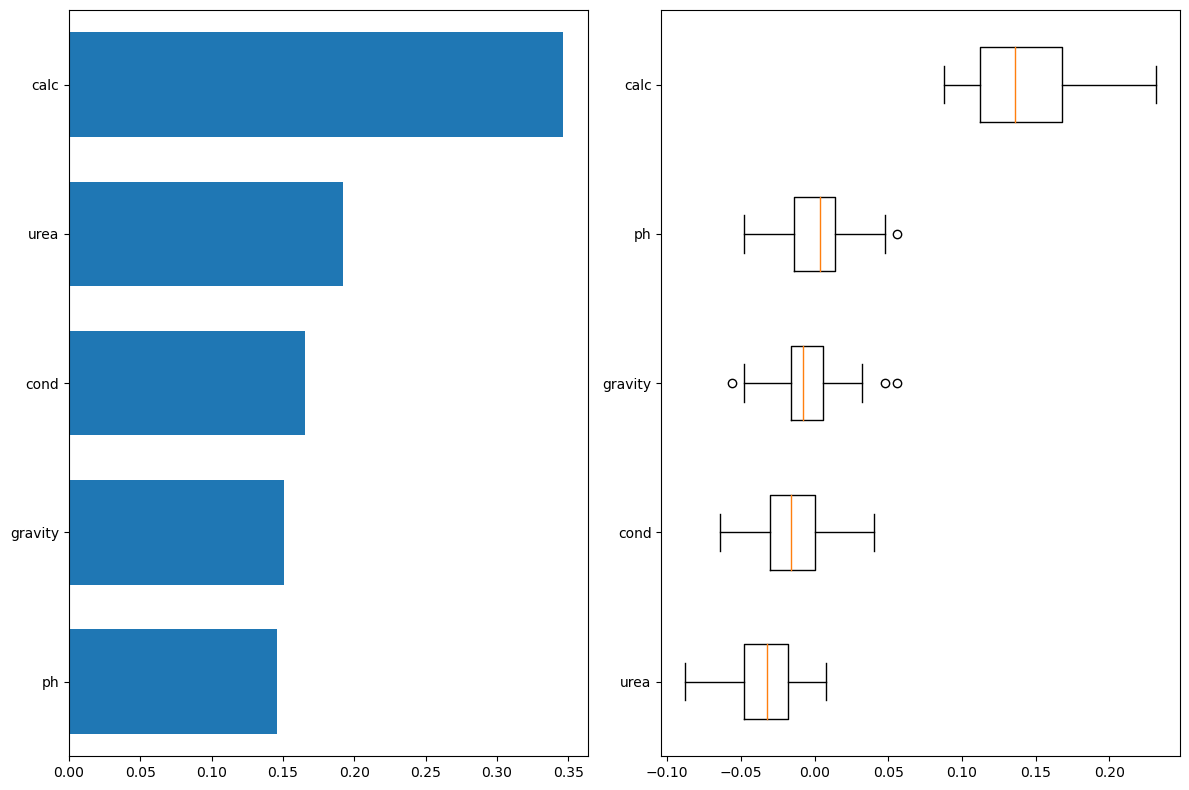

In [22]:
result = permutation_importance(rf, x_test, y_test, n_repeats=30, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(x_train.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=x_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

## Model Creation

### Random Forest 

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
pred_rf = np.zeros(df_test.shape[0])

#4,9,5

roc_rf = []# list contains rmse for each fold
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    

    
    # XGBoost regressor
    model_rf = RandomForestClassifier(n_estimators = 500, 
                                   max_depth = 4,
                                   min_samples_split = 15,
                                   min_samples_leaf = 5, 
                               random_state=42).fit(x_train, y_train)
    pred_rf+= model_rf.predict_proba(df_test)[:,1]/kfold.n_splits
    val_pred = model_rf.predict_proba(x_valid)[:,1]
    roc_rf.append(roc_auc_score(y_valid, val_pred))
    

    print(f"fold: {n+1} roc random forest: {roc_rf[n]}")
    n+=1
print(f"final rmsle is :{np.mean(roc_rf)}")   

fold: 1 roc random forest: 0.8625730994152048
fold: 2 roc random forest: 0.8091016548463357
fold: 3 roc random forest: 0.7072727272727273
fold: 4 roc random forest: 0.8694638694638694
fold: 5 roc random forest: 0.7416267942583732
final rmsle is :0.7980076290513021


### Gradiant Boosting

In [24]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
pred_gb = np.zeros(df_test.shape[0])



roc_gb = []# list contains rmse for each fold
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    

    
    # XGBoost regressor
    model_gb = GradientBoostingClassifier(n_estimators = 500, 
                                       learning_rate = 0.01,
                                       max_depth = 4,
                                       min_samples_split = 15,
                                       min_samples_leaf = 5).fit(x_train, y_train)
    pred_gb+= model_gb.predict_proba(df_test)[:,1]/kfold.n_splits
    val_pred = model_gb.predict_proba(x_valid)[:, 1]
    roc_gb.append(roc_auc_score(y_valid, val_pred))
    

    print(f"fold: {n+1} roc Gradiant Boosting: {roc_gb[n]}")
    n+=1
print(f"final rmsle is :{np.mean(roc_gb)}")   

fold: 1 roc Gradiant Boosting: 0.8631578947368421
fold: 2 roc Gradiant Boosting: 0.8020094562647754
fold: 3 roc Gradiant Boosting: 0.7003030303030302
fold: 4 roc Gradiant Boosting: 0.8356643356643356
fold: 5 roc Gradiant Boosting: 0.7392344497607656
final rmsle is :0.7880738333459498


### LGBM

In [25]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
pred_lgb = np.zeros(df_test.shape[0])



roc_lgb = []# list contains rmse for each fold
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    

    
    # XGBoost regressor
    model_lgb = LGBMClassifier(n_estimators = 500,
                           max_depth = 4,
                           learning_rate = 0.01,
                           num_leaves = 20,
                           reg_alpha = 3,
                           reg_lambda = 3,
                           subsample = 0.7,
                           colsample_bytree = 0.7, random_state=42).fit(x_train, y_train)
    pred_lgb+= model_lgb.predict_proba(df_test)[:,1]/kfold.n_splits
    val_pred = model_lgb.predict_proba(x_valid)[:, 1]
    roc_lgb.append(roc_auc_score(y_valid, val_pred))
    

    print(f"fold: {n+1} roc LGBM Classifier: {roc_lgb[n]}")
    n+=1
print(f"final rmsle is :{np.mean(roc_lgb)}")   

fold: 1 roc LGBM Classifier: 0.8654970760233919
fold: 2 roc LGBM Classifier: 0.817966903073286
fold: 3 roc LGBM Classifier: 0.6815151515151514
fold: 4 roc LGBM Classifier: 0.8723776223776223
fold: 5 roc LGBM Classifier: 0.7523923444976076
final rmsle is :0.7979498194974118


### XG Boost

In [26]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
pred_xgb = np.zeros(df_test.shape[0])



roc_xgb = []# list contains rmse for each fold
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    

    
    # XGBoost regressor
    model_xgb = XGBClassifier(
                          tree_method = 'hist',
                          colsample_bytree = 0.7, 
                          gamma = 2, 
                          learning_rate = 0.01, 
                          max_depth = 4, 
                          min_child_weight = 10, 
                          n_estimators = 500, 
                          subsample = 0.7, random_state=42).fit(x_train, y_train)
    pred_xgb+= model_xgb.predict_proba(df_test)[:,1]/kfold.n_splits
    val_pred = model_xgb.predict_proba(x_valid)[:, 1]
    roc_xgb.append(roc_auc_score(y_valid, val_pred))
    

    print(f"fold: {n+1} roc XGB Classifier: {roc_xgb[n]}")
    n+=1
print(f"final rmsle is :{np.mean(roc_xgb)}")   

fold: 1 roc XGB Classifier: 0.8438596491228071
fold: 2 roc XGB Classifier: 0.79225768321513
fold: 3 roc XGB Classifier: 0.6793939393939394
fold: 4 roc XGB Classifier: 0.8717948717948718
fold: 5 roc XGB Classifier: 0.771531100478469
final rmsle is :0.7917674488010435


### Cat Boost

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
pred_cat = np.zeros(df_test.shape[0])



roc_cat = []# list contains rmse for each fold
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    

    
    # XGBoost regressor
    model_cat = CatBoostClassifier(loss_function = 'Logloss',
                               iterations = 500,
                               learning_rate = 0.01,
                               depth = 4,
                               random_strength = 0.5,
                               bagging_temperature = 0.7,
                               border_count = 30,
                               l2_leaf_reg = 5,
                               verbose = False, random_state=42).fit(x_train, y_train)
    pred_cat+= model_cat.predict_proba(df_test)[:,1]/kfold.n_splits
    val_pred = model_cat.predict_proba(x_valid)[:, 1]
    roc_cat.append(roc_auc_score(y_valid, val_pred))
    

    print(f"fold: {n+1} roc cat boost Classifier: {roc_cat[n]}")
    n+=1
print(f"final rmsle is :{np.mean(roc_cat)}")   

fold: 1 roc cat boost Classifier: 0.8549707602339182
fold: 2 roc cat boost Classifier: 0.8126477541371158
fold: 3 roc cat boost Classifier: 0.6981818181818181
fold: 4 roc cat boost Classifier: 0.8613053613053613
fold: 5 roc cat boost Classifier: 0.764354066985646
final rmsle is :0.7982919521687719


### Ensemble Model

In [28]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')
submission['XGB'] = pred_xgb
submission['CAT'] = pred_cat
submission['LGB'] = pred_lgb
submission['RF'] = pred_rf

In [29]:
submission['target'] = (pred_xgb * 0.22 + pred_cat*0.26 + pred_lgb*0.26 + pred_rf * 0.26)

In [30]:
final_submission = submission[['id', 'target']]

In [31]:
final_submission

,id,target
0,414,0.192511
1,415,0.459396
2,416,0.796037
3,417,0.425230
4,418,0.334048
...,...,...
271,685,0.827790
272,686,0.118001
273,687,0.587914
274,688,0.187504


In [32]:
final_submission.to_csv('submission.csv', index=False)